# Cousera - Capstone Project - Week 5<BR>
### Author: Ratnesh Mehrotra

## Table of Content:
    Section 1: Build the dataset of all 5 Boroughs and their Neigbhourhoods as dataframe<BR>
    Section 2: Working with Foursquare APIs
    Section 3: Exploring the data of boroughs, neighbourhoods and venues 
    Section 4: Explore venues in neighbourhoods of the selected borough
    Section 5: Cluster the Neighbourhoods
    Section 6: Examine each cluster
    Section 7: Observation from Clusters

In [15]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge termcolor=1.1.0 --yes 
from termcolor import colored

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    termcolor: 1.1.0-py_2 conda-forge

termcolor-1.1. 100% |################################| Time: 0:00:00   6.99 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  53.36 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.21 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.25 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  47.99 MB/s
Fetchin

# SECTION 1: <br>Build the dataset of all 5 Boroughs and their Neigbhourhoods as dataframe

In order to segement the neighborhoods of the boroughs of New York City, and explore them, we will essentially need a dataset that contains the 5 boroughs, and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

This dataset is available for free at NYU Spatial Data Repositoy, and can be downloaded from: https://geo.nyu.edu/catalog/nyu_2451_34572

For the purpose of this project, the file which has already been downloaded on a server has been used. Its location is: https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json

In [16]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data) 

In [17]:
#All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

In [18]:
#Let's take a look at the first item in this list.
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

#### Tranform the data into a *pandas* dataframe
The next task is to transform the data .json format of nested Python dictionaries into a *pandas* dataframe. 
An empty dataframe is created at first for this.

In [19]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
all_boroughs_neighborhoods = pd.DataFrame(columns=column_names)

In [20]:
# loop through the data and fill the dataframe one row at a time.

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    all_boroughs_neighborhoods = all_boroughs_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(all_boroughs_neighborhoods['Borough'].unique()),
        all_boroughs_neighborhoods.shape[0]
    )
)
all_boroughs_neighborhoods = all_boroughs_neighborhoods.sort_values("Borough").reset_index(drop=True)

The dataframe has 5 boroughs and 306 neighborhoods.


In [21]:
all_boroughs_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Country Club,40.844246,-73.824099
2,Bronx,Parkchester,40.837938,-73.856003
3,Bronx,Westchester Square,40.840619,-73.842194
4,Bronx,Van Nest,40.843608,-73.866299


#### Use geopy library to get the latitude and longitude values of New York City.

In [22]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent='random')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top.

In [23]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(all_boroughs_neighborhoods['Latitude'], all_boroughs_neighborhoods['Longitude'], all_boroughs_neighborhoods['Borough'], all_boroughs_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# SECTION 2: <BR> Working with Foursquare APIs #

In this section, we make use of FourSquare APIs to get top 100 popular venues within a defined radius for a given neighbourhood. For this, latitude and longitude of the neighbourhood are passed to the API.

In [55]:
# parameters to be used for building the URL as specified by FourSquare
CLIENT_ID = 'YCERJ444XMQAXGEERYBGUNEIULI0IJ5LALYLHBVH0WCYCRQU' 
CLIENT_SECRET = 'FTQXQMWZIM4TBLPGH02ZHC1QAIVZ1O3NRRCHSMKOUFQNYRYZ' 
VERSION = '20180604'

LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 2000 # define radius

In [25]:
# returns a list of unique neighbourhoods & their geo coordinates given the borough name
def get_neighbourhoods_df(borough_name):
    neighbourhood_data = all_boroughs_neighborhoods[all_boroughs_neighborhoods['Borough'] == borough_name]
    # create a dataframe with unique Neighbourhood, latituded and longitude for manhattan
    neighbourhood_data.groupby( ['Borough','Neighborhood', 'Latitude', 'Longitude'] ).size().to_frame(name = 'count')
    return neighbourhood_data

In [56]:
# Function to return a URL
def get_venue_explore_url(lat,long):
    # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        RADIUS, 
        LIMIT)
    return url 

In [27]:
# All the information is in the *items* key. **get_category_type** function from the Foursquare lab.
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
# function which will be called to retrieve popular venues for a given lat & long of a neighbourhood
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
         
        # create the API request URL
        url = get_venue_explore_url(lat,lng)
       
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [29]:
#our interest is in only venues belonging to following categories only. This criteria shall be used to select only matching records
venue_filter="Movie Theater|Indian Restaurant|Chinese Restaurant|Mall"

In [30]:
# Create an empty dataframe, which will be populated with counts of venues for each borough and used to create a bar chart
bar_columns = ['Borough','Movie Theater','Indian Restaurant','Chinese Restaurant','Shopping Malls']
df_bar_chart = pd.DataFrame(columns=bar_columns)

In [31]:
#this function iterates over the Grouped By dataframe.
def populate_df_for_barchart (borough, df):
    list_as_row = [borough,0,0,0,0]
    for index, row in df.iterrows():
        if row["Venue Category"]=='Movie Theater': list_as_row[1]= row["counts"]
        if row["Venue Category"]=='Indian Restaurant': list_as_row[2]= row["counts"]
        if row["Venue Category"]=='Chinese Restaurant': list_as_row[3]= row["counts"]
        if row["Venue Category"]=='Shopping Mall': list_as_row[4]= row["counts"]  
    df_bar_chart.loc[len(df_bar_chart)] = list_as_row        

# SECTION 3: <BR> Exploring the data of boroughs, neighbourhoods and venues #

In this section, we will explore the data collected for boroughs, their neighbourhoods and the venues of our interest.
The objective is to understand the distribution of venues of interest across boroughs

#### Staten Island

In [32]:
#Build the dataframe with venues in all neighbourhoods
staten_data = get_neighbourhoods_df("Staten Island")
staten_neighbor_venues = getNearbyVenues(names=staten_data['Neighborhood'],
                                   latitudes=staten_data['Latitude'],
                                   longitudes=staten_data['Longitude'],
                                  )

In [33]:
movie_theater_locations_staten = staten_neighbor_venues[staten_neighbor_venues['Venue Category'].str.contains(venue_filter)]
movie_theater_locations_staten = movie_theater_locations_staten.drop(movie_theater_locations_staten[movie_theater_locations_staten["Venue Category"] == "Indie Movie Theater"].index)
movie_theater_locations_staten.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Elm Park,40.630147,-74.141817,Crown Palace,40.626593,-74.131930,Chinese Restaurant
30,Elm Park,40.630147,-74.141817,Fortune Cookie,40.626244,-74.134688,Chinese Restaurant
106,Howland Hook,40.638433,-74.186223,United Artists Staten Island 16 & RPX,40.626312,-74.172686,Movie Theater
149,Randall Manor,40.635630,-74.098051,Dosa Garden,40.634231,-74.085696,Indian Restaurant
233,Randall Manor,40.635630,-74.098051,Diamond Forest Chinese Food Restaurant,40.630977,-74.100951,Chinese Restaurant


In [34]:
df_bar_stat = (movie_theater_locations_staten.groupby(['Venue Category']).size().reset_index(name='counts'))
df_bar_stat

,Venue Category,counts
0,Chinese Restaurant,65
1,Indian Restaurant,17
2,Movie Theater,4
3,Shopping Mall,7


In [35]:
populate_df_for_barchart("Staten Island",df_bar_stat)
df_bar_chart

,Borough,Movie Theater,Indian Restaurant,Chinese Restaurant,Shopping Malls
0,Staten Island,4,17,65,7


#### Manhattan

In [36]:
#Build the dataframe with venues in all neighbourhoods
manhattan_data = get_neighbourhoods_df("Manhattan")
manhattan_neighbor_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                  )

In [37]:
movie_theater_locations_man = manhattan_neighbor_venues[manhattan_neighbor_venues['Venue Category'].str.contains(venue_filter)]
movie_theater_locations_man = movie_theater_locations_man.drop(movie_theater_locations_man[movie_theater_locations_man["Venue Category"] == "Indie Movie Theater"].index)
movie_theater_locations_man.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Chinatown,40.715618,-73.994279,Shanghai Asian Manor,40.714423,-73.998904,Chinese Restaurant
236,Carnegie Hill,40.782683,-73.953256,Drunken Munkey,40.781106,-73.947549,Indian Restaurant
419,Flatiron,40.739673,-73.990947,Xi'an Famous Foods,40.740632,-73.987346,Chinese Restaurant
530,Stuyvesant Town,40.731000,-73.974052,Xi'an Famous Foods,40.727731,-73.985652,Chinese Restaurant
544,Stuyvesant Town,40.731000,-73.974052,Han Dynasty,40.732130,-73.988090,Chinese Restaurant


In [38]:
df_bar_man = (movie_theater_locations_man.groupby(['Venue Category']).size().reset_index(name='counts'))
df_bar_man

,Venue Category,counts
0,Chinese Restaurant,41
1,Indian Restaurant,17
2,Movie Theater,3
3,North Indian Restaurant,2
4,Shopping Mall,4


In [39]:
populate_df_for_barchart("Manhattan",df_bar_man)
df_bar_chart

,Borough,Movie Theater,Indian Restaurant,Chinese Restaurant,Shopping Malls
0,Staten Island,4,17,65,7
1,Manhattan,3,17,41,4


#### Brooklyn

In [40]:
#Build the dataframe with venues in all neighbourhoods
brooklyn_data = get_neighbourhoods_df("Brooklyn")
brooklyn_neighbor_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude'],
                                  )


In [41]:
movie_theater_locations_brook = brooklyn_neighbor_venues[brooklyn_neighbor_venues['Venue Category'].str.contains(venue_filter)]
movie_theater_locations_brook = movie_theater_locations_brook.drop(movie_theater_locations_brook[movie_theater_locations_brook["Venue Category"] == "Indie Movie Theater"].index)
movie_theater_locations_brook.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown,40.690844,-73.983463,Alamo Drafthouse Cinema - Brooklyn,40.691016,-73.983686,Movie Theater
112,Erasmus,40.646926,-73.948177,Gandhi Fine Indian Cuisine,40.655168,-73.956325,Indian Restaurant
139,Erasmus,40.646926,-73.948177,China Hao Restaurant,40.650186,-73.930144,Chinese Restaurant
148,Erasmus,40.646926,-73.948177,Green Lake Chinese Restaurant,40.653110,-73.959343,Chinese Restaurant
195,Erasmus,40.646926,-73.948177,Silver Krust,40.642391,-73.926620,Indian Restaurant


In [42]:
df_bar_brook = (movie_theater_locations_brook.groupby(['Venue Category']).size().reset_index(name='counts'))
df_bar_brook

,Venue Category,counts
0,Chinese Restaurant,97
1,Indian Restaurant,42
2,Movie Theater,14
3,Shopping Mall,4


In [43]:
populate_df_for_barchart("Brooklyn",df_bar_brook)
df_bar_chart

,Borough,Movie Theater,Indian Restaurant,Chinese Restaurant,Shopping Malls
0,Staten Island,4,17,65,7
1,Manhattan,3,17,41,4
2,Brooklyn,14,42,97,4


#### Bronx

In [57]:
#Build the dataframe with venues in all neighbourhoods
bronx_data = get_neighbourhoods_df("Bronx")
bronx_data_neighbor_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude'],
                                  )

In [58]:
movie_theater_locations_bronx = bronx_data_neighbor_venues[bronx_data_neighbor_venues['Venue Category'].str.contains(venue_filter)]
movie_theater_locations_bronx = movie_theater_locations_bronx.drop(movie_theater_locations_bronx[movie_theater_locations_bronx["Venue Category"] == "Indie Movie Theater"].index)
movie_theater_locations_bronx.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
27,Wakefield,40.894705,-73.847201,Curry Spot,40.897625,-73.867147,Indian Restaurant
63,Wakefield,40.894705,-73.847201,Shopwell Plaza,40.884144,-73.832001,Shopping Mall
456,Van Nest,40.843608,-73.866299,Peking Kitchen,40.854462,-73.866608,Chinese Restaurant
555,Morris Park,40.847549,-73.850402,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant
578,Morris Park,40.847549,-73.850402,Peking Kitchen,40.854462,-73.866608,Chinese Restaurant


In [59]:
df_bar_bronx = (movie_theater_locations_bronx.groupby(['Venue Category']).size().reset_index(name='counts'))
df_bar_bronx

,Venue Category,counts
0,Chinese Restaurant,41
1,Indian Restaurant,11
2,Movie Theater,2
3,Shopping Mall,26


In [60]:
populate_df_for_barchart("Bronx",df_bar_bronx)
df_bar_chart

,Borough,Movie Theater,Indian Restaurant,Chinese Restaurant,Shopping Malls
0,Staten Island,4,17,65,7
1,Manhattan,3,17,41,4
2,Brooklyn,14,42,97,4
3,Bronx,2,11,41,26


#### Queens

In [61]:
#Build the dataframe with venues in all neighbourhoods
queens_data = get_neighbourhoods_df("Queens")
queens_data_neighbor_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude'],
                                  )


In [62]:
#Get the count of each category
movie_theater_locations_queens = queens_data_neighbor_venues[queens_data_neighbor_venues['Venue Category'].str.contains(venue_filter)]
movie_theater_locations_queens = movie_theater_locations_queens.drop(movie_theater_locations_queens[movie_theater_locations_queens["Venue Category"] == "Indie Movie Theater"].index)
movie_theater_locations_queens.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
60,Laurelton,40.667884,-73.740256,Green Acres Commons,40.663338,-73.726654,Shopping Mall
107,Lefrak City,40.736075,-73.862525,Rego Center,40.732896,-73.863135,Shopping Mall
142,Lefrak City,40.736075,-73.862525,Green Zenphony,40.730528,-73.863641,Chinese Restaurant
171,Lefrak City,40.736075,-73.862525,Queens Center,40.734723,-73.870041,Shopping Mall
236,Belle Harbor,40.576156,-73.854018,East Meets West,40.578435,-73.849474,Chinese Restaurant


In [63]:
df_bar_queens = (movie_theater_locations_queens.groupby(['Venue Category']).size().reset_index(name='counts'))
df_bar_queens

,Venue Category,counts
0,Chinese Restaurant,163
1,Indian Restaurant,109
2,Movie Theater,16
3,Shopping Mall,23


In [64]:
populate_df_for_barchart("Queens",df_bar_queens)
df_bar_chart

,Borough,Movie Theater,Indian Restaurant,Chinese Restaurant,Shopping Malls
0,Staten Island,4,17,65,7
1,Manhattan,3,17,41,4
2,Brooklyn,14,42,97,4
3,Bronx,2,11,41,26
4,Queens,16,109,163,23


### Plot a barchart showing total count of selected venues in each borough

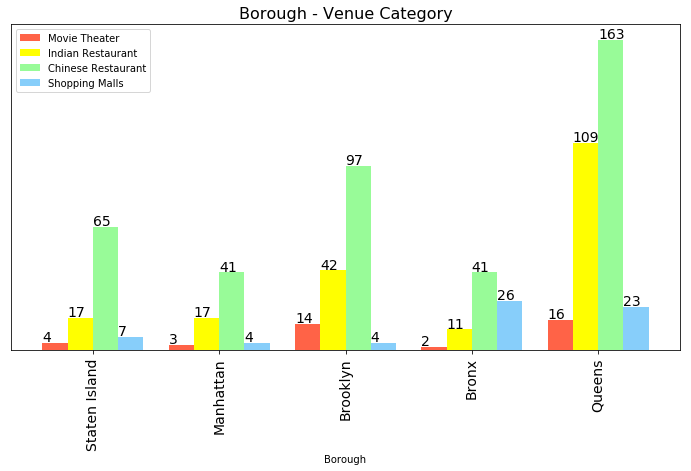

In [65]:
df_bar_chart.set_index("Borough",inplace = True)
title='Borough - Venue Category'
#df_survey = df_bar_chart
ax = df_bar_chart.plot(kind='bar', figsize=(12, 6), color=['#FF6347','#FFFF00','#98FB98','#87CEFA'], fontsize=14, width=0.8)

#set title in fontsize 16
ax.set_title(title, fontsize=16)

#print figure over bars
for counter in ax.patches:
    ax.text(counter.get_x(), counter.get_height()+0.8, \
            str(round((counter.get_height()), 2)), \
            fontsize=14, \
            color='black', \
            rotation=0)

#remove left, top and right borders; and y-axis
ax.set_frame_on(True)
ax.spines['top'].set_visible(True) 
ax.spines['left'].set_visible(True) 
ax.spines['right'].set_visible(True) 
ax.get_yaxis().set_visible(False)

#### Inference from the bar chart:
As visible from the barchart above, Queens seems to have a good proportion of Movie Theaters, Indian & Chinese Restaurants and Shopping Malls. This would be an ideal place for screening of movies, as movie goers will have more options of venues for dining out and shopping.

*Hence we shall be selecting Queens as the borough for further analysis, segmentation and applying clustering algorithm*

In [66]:
movie_theater_locations_queens.head(50)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
60,Laurelton,40.667884,-73.740256,Green Acres Commons,40.663338,-73.726654,Shopping Mall
107,Lefrak City,40.736075,-73.862525,Rego Center,40.732896,-73.863135,Shopping Mall
142,Lefrak City,40.736075,-73.862525,Green Zenphony,40.730528,-73.863641,Chinese Restaurant
171,Lefrak City,40.736075,-73.862525,Queens Center,40.734723,-73.870041,Shopping Mall
236,Belle Harbor,40.576156,-73.854018,East Meets West,40.578435,-73.849474,Chinese Restaurant
308,Rockaway Park,40.580343,-73.841534,East Meets West,40.578435,-73.849474,Chinese Restaurant
357,Brookville,40.660003,-73.751753,Win Chinese Store,40.657945,-73.736228,Chinese Restaurant
405,Bellaire,40.733014,-73.738892,China King,40.728896,-73.737284,Chinese Restaurant
425,Bellaire,40.733014,-73.738892,Taste of Cochin,40.742316,-73.721640,Indian Restaurant
433,Bellaire,40.733014,-73.738892,The Hibiscus Restaurant & Lounge II,40.720150,-73.732745,Chinese Restaurant


In [67]:
#Let's print out the count of categories we have selected
unique_categories = len(movie_theater_locations_queens['Venue Category'].unique())
print('There are {} uniques categories.'.format(unique_categories))

There are 4 uniques categories.


In [68]:
#assign the dataset of selected borough to placeholder variable for further analysis
venues_of_interest_filtered = movie_theater_locations_queens

# SECTION 4: <BR> Explore venues in neighbourhoods of the selected borough #

In this section we hot encode the categorical values into integer data values to be able to work with clustering algorithms

In [69]:
# one hot encoding
venues_of_interest_onehot = pd.get_dummies(venues_of_interest_filtered[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_of_interest_onehot['Neighborhood'] = venues_of_interest_filtered['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_of_interest_onehot.columns[-1]] + list(venues_of_interest_onehot.columns[:-1])
venues_of_interest_onehot = venues_of_interest_onehot[fixed_columns]

venues_of_interest_onehot.head()

,Neighborhood,Chinese Restaurant,Indian Restaurant,Movie Theater,Shopping Mall
60,Laurelton,0,0,0,1
107,Lefrak City,0,0,0,1
142,Lefrak City,1,0,0,0
171,Lefrak City,0,0,0,1
236,Belle Harbor,1,0,0,0


In [70]:
print(venues_of_interest_onehot.shape)

(311, 5)


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [89]:
venues_of_interest_grouped = venues_of_interest_onehot.groupby('Neighborhood').mean().reset_index()
venues_of_interest_grouped.head()

,Neighborhood,Chinese Restaurant,Indian Restaurant,Movie Theater,Shopping Mall
0,Arverne,1.000000,0.000000,0.0,0.0
1,Astoria,0.000000,1.000000,0.0,0.0
2,Astoria Heights,0.666667,0.333333,0.0,0.0
3,Auburndale,0.000000,1.000000,0.0,0.0
4,Bay Terrace,0.250000,0.250000,0.0,0.5


Let's print each neighborhood along with their venues & frequency of occurrence

In [90]:
num_top_venues = 4

for hood in venues_of_interest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_of_interest_grouped[venues_of_interest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
                venue  freq
0  Chinese Restaurant   1.0
1   Indian Restaurant   0.0
2       Movie Theater   0.0
3       Shopping Mall   0.0


----Astoria----
                venue  freq
0   Indian Restaurant   1.0
1  Chinese Restaurant   0.0
2       Movie Theater   0.0
3       Shopping Mall   0.0


----Astoria Heights----
                venue  freq
0  Chinese Restaurant  0.67
1   Indian Restaurant  0.33
2       Movie Theater  0.00
3       Shopping Mall  0.00


----Auburndale----
                venue  freq
0   Indian Restaurant   1.0
1  Chinese Restaurant   0.0
2       Movie Theater   0.0
3       Shopping Mall   0.0


----Bay Terrace----
                venue  freq
0       Shopping Mall  0.50
1  Chinese Restaurant  0.25
2   Indian Restaurant  0.25
3       Movie Theater  0.00


----Bayside----
                venue  freq
0   Indian Restaurant  0.67
1       Shopping Mall  0.33
2  Chinese Restaurant  0.00
3       Movie Theater  0.00


----Bayswater----
                ven

#### Table: Common Venues
This displays the venues for each neighborhood in decreasing order of occurence. Let's put that into a pandas dataframe

In [91]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [92]:
num_top_venues = len(venues_of_interest_filtered['Venue Category'].unique()) ##************

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_of_interest_grouped['Neighborhood']

for ind in np.arange(venues_of_interest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_of_interest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Arverne,Chinese Restaurant,Shopping Mall,Movie Theater,Indian Restaurant
1,Astoria,Indian Restaurant,Shopping Mall,Movie Theater,Chinese Restaurant
2,Astoria Heights,Chinese Restaurant,Indian Restaurant,Shopping Mall,Movie Theater
3,Auburndale,Indian Restaurant,Shopping Mall,Movie Theater,Chinese Restaurant
4,Bay Terrace,Shopping Mall,Indian Restaurant,Chinese Restaurant,Movie Theater
5,Bayside,Indian Restaurant,Shopping Mall,Movie Theater,Chinese Restaurant
6,Bayswater,Chinese Restaurant,Shopping Mall,Movie Theater,Indian Restaurant
7,Beechhurst,Chinese Restaurant,Shopping Mall,Movie Theater,Indian Restaurant
8,Bellaire,Indian Restaurant,Chinese Restaurant,Shopping Mall,Movie Theater
9,Belle Harbor,Chinese Restaurant,Shopping Mall,Movie Theater,Indian Restaurant


# SECTION 5: <BR> Cluster the Neighbourhoods #

In this section we create a cluster of neighbourhoods using the K-Means clustering. For this, we first plot the graph to get the <B>ELBOW</B> point for optimum K-value

In [93]:
#venues_of_interest_grouped is the dataframe with numerical values as means
venues_of_interest_grouped_for_kmeans = venues_of_interest_grouped.drop('Neighborhood', 1)

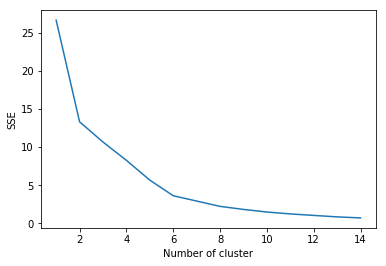

In [94]:
# Determine an optimum K value
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(venues_of_interest_grouped_for_kmeans)
    venues_of_interest_grouped_for_kmeans["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

K-value is taken to be as 6

In [95]:
# set number of clusters
kclusters = 6

In [96]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_of_interest_grouped_for_kmeans)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
print(len(kmeans.labels_))

78


In [97]:
Final_Neigbourhoods_Of_Interest = venues_of_interest_grouped 
Final_Neigbourhoods_Of_Interest.head()

,Neighborhood,Chinese Restaurant,Indian Restaurant,Movie Theater,Shopping Mall
0,Arverne,1.000000,0.000000,0.0,0.0
1,Astoria,0.000000,1.000000,0.0,0.0
2,Astoria Heights,0.666667,0.333333,0.0,0.0
3,Auburndale,0.000000,1.000000,0.0,0.0
4,Bay Terrace,0.250000,0.250000,0.0,0.5


In [98]:
# add clustering labels
Final_Neigbourhoods_Of_Interest['Cluster Labels'] = kmeans.labels_
Final_Neigbourhoods_Of_Interest.head()

,Neighborhood,Chinese Restaurant,Indian Restaurant,Movie Theater,Shopping Mall,Cluster Labels
0,Arverne,1.000000,0.000000,0.0,0.0,0
1,Astoria,0.000000,1.000000,0.0,0.0,3
2,Astoria Heights,0.666667,0.333333,0.0,0.0,1
3,Auburndale,0.000000,1.000000,0.0,0.0,3
4,Bay Terrace,0.250000,0.250000,0.0,0.5,0


In [99]:
#create a sorted dataframe, with sorting on "Neighborhood"
temp = pd.merge(Final_Neigbourhoods_Of_Interest, venues_of_interest_filtered, on='Neighborhood', how='inner')
Final_Neigbourhoods_Of_Interest = temp.sort_values("Neighborhood")
Final_Neigbourhoods_Of_Interest.head()

,Neighborhood,Chinese Restaurant,Indian Restaurant,Movie Theater,Shopping Mall,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arverne,1.0,0.0,0.0,0.0,0,40.589144,-73.791992,301 Chinese Resturant,40.587409,-73.811638,Chinese Restaurant
1,Arverne,1.0,0.0,0.0,0.0,0,40.589144,-73.791992,Happy Wok,40.592908,-73.795996,Chinese Restaurant
2,Arverne,1.0,0.0,0.0,0.0,0,40.589144,-73.791992,Golden Lee Chinese Restaurant,40.594535,-73.770300,Chinese Restaurant
3,Astoria,0.0,1.0,0.0,0.0,3,40.768509,-73.915654,Seva Indian Cuisine,40.765521,-73.919157,Indian Restaurant
4,Astoria,0.0,1.0,0.0,0.0,3,40.768509,-73.915654,Yaar Indian Restaurant,40.774867,-73.912129,Indian Restaurant


#### Finally, let's visualize the resulting clusters

In [100]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Final_Neigbourhoods_Of_Interest['Neighborhood Latitude'], Final_Neigbourhoods_Of_Interest['Neighborhood Longitude'], Final_Neigbourhoods_Of_Interest['Neighborhood'], Final_Neigbourhoods_Of_Interest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# SECTION 6: <BR>Examine each cluster #

In this section, we explore each cluster further, and at the end, plot a barchart, plotting distribution of each venue category within the cluster

In [101]:
# Create an empty dataframe, which will be populated with counts of venues for each borough and used to create a bar chart
bar_columns_cluster = ['Cluster','Theater','Indian Restaurant','Chinese Restaurant','Shopping Malls']
df_bar_chart_cluster = pd.DataFrame(columns=bar_columns_cluster)

#this function iterates over the Grouped By dataframe.
def populate_df_for_barchart_clusters (cluster, df):
    list_as_row = [cluster,0,0,0,0]
    for index, row in df.iterrows():
        if row["Venue Category"]=='Movie Theater': list_as_row[1]= row["counts"]
        if row["Venue Category"]=='Indian Restaurant': list_as_row[2]= row["counts"]
        if row["Venue Category"]=='Chinese Restaurant': list_as_row[3]= row["counts"]
        if row["Venue Category"]=='Shopping Mall': list_as_row[4]= row["counts"]  
    df_bar_chart_cluster.loc[len(df_bar_chart_cluster)] = list_as_row   

In [102]:
list_of_cluster_df = []
list_of_cluster_summary_df = []

for counter in range(kclusters):
    df_cluster = Final_Neigbourhoods_Of_Interest.loc[Final_Neigbourhoods_Of_Interest['Cluster Labels'] == counter, Final_Neigbourhoods_Of_Interest.columns[[0] + list(range(unique_categories+1, Final_Neigbourhoods_Of_Interest.shape[1]))]].sort_values(["Venue Category"])
    df_summary_cluster = (df_cluster[['Neighborhood', 'Cluster Labels', 'Venue', 'Venue Category']].groupby("Venue Category")).size().reset_index(name='counts')

    list_of_cluster_df.append(df_cluster)
    list_of_cluster_summary_df.append(df_summary_cluster)
    
    label_for_barchart = "Cluster# {}".format(counter+1)
    populate_df_for_barchart_clusters (label_for_barchart, df_summary_cluster)  

In [103]:
counter = 1
for df_temp in list_of_cluster_df:
    #print("\n")
    print(colored("CLUSTER # {}".format(counter), 'red'))
    print("\n")
    print(colored("Summary View".format(counter), 'blue'))
    display(list_of_cluster_summary_df[counter-1])
    
    print("\n")
    print(colored("Detail View".format(counter), 'blue'))
    display(df_temp)
    print("\n")
    counter = counter +1

CLUSTER # 1


Summary View


,Venue Category,counts
0,Chinese Restaurant,69
1,Indian Restaurant,5
2,Shopping Mall,2




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arverne,0,40.589144,-73.791992,301 Chinese Resturant,40.587409,-73.811638,Chinese Restaurant
217,North Corona,0,40.754071,-73.857518,Mi Estrella,40.748377,-73.877473,Chinese Restaurant
216,North Corona,0,40.754071,-73.857518,El Jardin De China,40.750670,-73.870035,Chinese Restaurant
215,Neponsit,0,40.572037,-73.857547,East Meets West,40.578435,-73.849474,Chinese Restaurant
214,Murray Hill,0,40.764126,-73.812763,Asian Jewels Seafood Restaurant 敦城海鲜酒家,40.759210,-73.833253,Chinese Restaurant
208,Murray Hill,0,40.764126,-73.812763,Taipei Hong 台北夯,40.760149,-73.828162,Chinese Restaurant
205,Murray Hill,0,40.764126,-73.812763,DunHuang Lanzhou Beef Noodle,40.762316,-73.827633,Chinese Restaurant
250,Queensboro Hill,0,40.744572,-73.825809,New Golden Szechuan Chinese Restaurant,40.758791,-73.832610,Chinese Restaurant
207,Murray Hill,0,40.764126,-73.812763,Fu Run 賦潤東北美食,40.758641,-73.831645,Chinese Restaurant
209,Murray Hill,0,40.764126,-73.812763,Laoma Mala Tang,40.759608,-73.829842,Chinese Restaurant




CLUSTER # 2


Summary View


,Venue Category,counts
0,Chinese Restaurant,23
1,Indian Restaurant,16
2,Movie Theater,7
3,Shopping Mall,1




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Astoria Heights,1,40.770317,-73.894680,Xing Chef,40.769886,-73.901964,Chinese Restaurant
295,Sunnyside Gardens,1,40.745652,-73.918193,Xi’an Famous Foods Central Kitchen,40.750899,-73.906499,Chinese Restaurant
265,Richmond Hill,1,40.697947,-73.831833,Ho Wan Restaurant,40.684857,-73.830962,Chinese Restaurant
264,Richmond Hill,1,40.697947,-73.831833,Bamboo Gardens,40.690992,-73.838062,Chinese Restaurant
269,Richmond Hill,1,40.697947,-73.831833,Chopsticks,40.685992,-73.825172,Chinese Restaurant
259,Rego Park,1,40.728974,-73.857827,Green Zenphony,40.730528,-73.863641,Chinese Restaurant
234,Queens Village,1,40.718893,-73.738715,The Hibiscus Restaurant & Lounge II,40.720150,-73.732745,Chinese Restaurant
235,Queens Village,1,40.718893,-73.738715,China King,40.728896,-73.737284,Chinese Restaurant
227,Ozone Park,1,40.680708,-73.843203,Danny's Szechuan Garden,40.663122,-73.841426,Chinese Restaurant
226,Ozone Park,1,40.680708,-73.843203,Chopsticks,40.685992,-73.825172,Chinese Restaurant




CLUSTER # 3


Summary View


,Venue Category,counts
0,Chinese Restaurant,49
1,Indian Restaurant,30
2,Movie Theater,1
3,Shopping Mall,6




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
27,Bellaire,2,40.733014,-73.738892,The Hibiscus Restaurant & Lounge II,40.720150,-73.732745,Chinese Restaurant
137,Hollis,2,40.711243,-73.759250,Hong Kong Restaurant,40.715842,-73.771432,Chinese Restaurant
149,Jackson Heights,2,40.751981,-73.882821,El Jardin De China,40.750670,-73.870035,Chinese Restaurant
292,Sunnyside,2,40.740176,-73.926916,Golden Wok,40.745251,-73.921450,Chinese Restaurant
152,Jackson Heights,2,40.751981,-73.882821,Lao Bei Fang,40.741078,-73.879996,Chinese Restaurant
158,Jamaica Center,2,40.704657,-73.796902,Chef's Garden,40.721165,-73.804375,Chinese Restaurant
156,Jamaica Center,2,40.704657,-73.796902,Sagar Chinese,40.711129,-73.793021,Chinese Restaurant
161,Jamaica Estates,2,40.716805,-73.787227,Sagar Chinese,40.711129,-73.793021,Chinese Restaurant
162,Jamaica Estates,2,40.716805,-73.787227,Chef's Garden,40.721165,-73.804375,Chinese Restaurant
166,Jamaica Hills,2,40.711460,-73.796465,Sagar Chinese,40.711129,-73.793021,Chinese Restaurant




CLUSTER # 4


Summary View


,Venue Category,counts
0,Chinese Restaurant,8
1,Indian Restaurant,52
2,Movie Theater,1
3,Shopping Mall,1




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
280,South Jamaica,3,40.696911,-73.790426,Sagar Chinese,40.711129,-73.793021,Chinese Restaurant
304,Woodside,3,40.746349,-73.901842,Peking BBQ Chicken,40.745488,-73.906053,Chinese Restaurant
305,Woodside,3,40.746349,-73.901842,Xi’an Famous Foods Central Kitchen,40.750899,-73.906499,Chinese Restaurant
124,Glen Oaks,3,40.749441,-73.715481,QQ CAFE Noodle House,40.760134,-73.731537,Chinese Restaurant
47,Briarwood,3,40.710935,-73.811748,Chef's Garden,40.721165,-73.804375,Chinese Restaurant
38,Bellerose,3,40.728573,-73.720128,China King,40.728896,-73.737284,Chinese Restaurant
39,Bellerose,3,40.728573,-73.720128,The Hibiscus Restaurant & Lounge II,40.720150,-73.732745,Chinese Restaurant
46,Briarwood,3,40.710935,-73.811748,Panda Garden,40.718376,-73.815084,Chinese Restaurant
120,Glen Oaks,3,40.749441,-73.715481,Mumbai Xpress,40.736745,-73.711754,Indian Restaurant
116,Glen Oaks,3,40.749441,-73.715481,Santoor Indian Restaurant,40.745936,-73.714231,Indian Restaurant




CLUSTER # 5


Summary View


,Venue Category,counts
0,Chinese Restaurant,2
1,Indian Restaurant,6
2,Movie Theater,5
3,Shopping Mall,2




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
186,Lindenwood,4,40.663918,-73.849638,Danny's Szechuan Garden,40.663122,-73.841426,Chinese Restaurant
300,Utopia,4,40.733500,-73.796717,Chef's Garden,40.721165,-73.804375,Chinese Restaurant
174,Kew Gardens,4,40.705179,-73.829819,Sohna Punjab,40.693666,-73.829235,Indian Restaurant
176,Kew Gardens,4,40.705179,-73.829819,Haveli,40.715705,-73.832922,Indian Restaurant
172,Kew Gardens,4,40.705179,-73.829819,Tikka Indian Grill,40.705728,-73.830557,Indian Restaurant
173,Kew Gardens,4,40.705179,-73.829819,Mehak Mughlai Cuisine,40.709164,-73.829509,Indian Restaurant
255,Ravenswood,4,40.761705,-73.931575,Boishakhi Restaurant,40.757089,-73.930951,Indian Restaurant
256,Ravenswood,4,40.761705,-73.931575,Seva Indian Cuisine,40.765521,-73.919157,Indian Restaurant
175,Kew Gardens,4,40.705179,-73.829819,Cinemart Cinemas,40.709984,-73.847040,Movie Theater
171,Kew Gardens,4,40.705179,-73.829819,Kew Gardens Cinema,40.709045,-73.829682,Movie Theater




CLUSTER # 6


Summary View


,Venue Category,counts
0,Chinese Restaurant,12
1,Movie Theater,2
2,Shopping Mall,11




Detail View


,Neighborhood,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
302,Whitestone,5,40.781291,-73.814202,Keilly Chinese Restaurant,40.786956,-73.835675,Chinese Restaurant
22,Beechhurst,5,40.792781,-73.804365,Baybridge Szechuan Cuisine,40.788592,-73.785396,Chinese Restaurant
23,Beechhurst,5,40.792781,-73.804365,A Taste Of China Chinese Food,40.796999,-73.823541,Chinese Restaurant
24,Beechhurst,5,40.792781,-73.804365,Keilly Chinese Restaurant,40.777662,-73.793593,Chinese Restaurant
272,Rochdale,5,40.675211,-73.772588,Yummy Express,40.665371,-73.776741,Chinese Restaurant
66,Corona,5,40.742382,-73.856825,El Jardin De China,40.750670,-73.870035,Chinese Restaurant
127,Glendale,5,40.702762,-73.870742,Jade Bamboo,40.718166,-73.872568,Chinese Restaurant
128,Glendale,5,40.702762,-73.870742,Wing Wah Chinese Restaurant,40.711025,-73.854240,Chinese Restaurant
184,Lefrak City,5,40.736075,-73.862525,Green Zenphony,40.730528,-73.863641,Chinese Restaurant
200,Middle Village,5,40.716415,-73.881143,Jade Bamboo,40.718166,-73.872568,Chinese Restaurant


## Plot a barchart showing counts of selected venues in each cluster

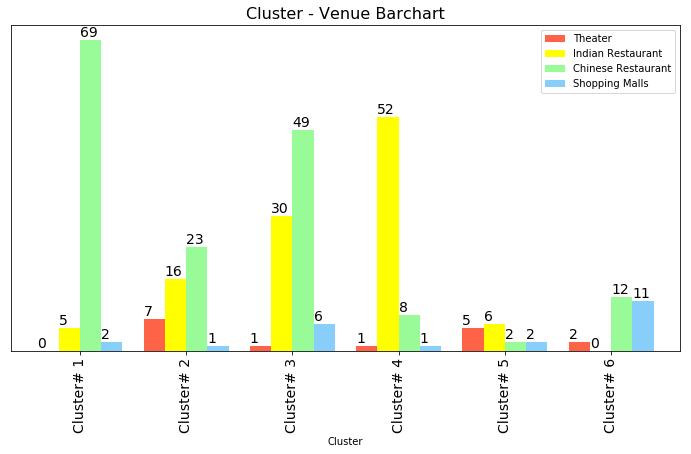

In [104]:
df_bar_chart_cluster.set_index("Cluster",inplace = True)
title='Cluster - Venue Barchart'

ax = df_bar_chart_cluster.plot(kind='bar', figsize=(12, 6), color=['#FF6347','#FFFF00','#98FB98','#87CEFA'], fontsize=14, width=0.8)

#set title in fontsize 16
ax.set_title(title, fontsize=16)

#print figure over bars
for counter in ax.patches:
    ax.text(counter.get_x(), counter.get_height()+0.8, \
            str(round((counter.get_height()), 2)), \
            fontsize=14, \
            color='black', \
            rotation=0)

#remove left, top and right borders; and y-axis
ax.set_frame_on(True)
ax.spines['top'].set_visible(True) 
ax.spines['left'].set_visible(True) 
ax.spines['right'].set_visible(True) 
ax.get_yaxis().set_visible(False)

# Section 7:<BR>Observation from this run of k-Means clustering algorithm

Cluster 3 seem to be the best cluster in this iteration, having good number of restaurants and shopping malls